<a href="https://colab.research.google.com/github/ria-heikkila/fish_species_recognizer/blob/master/fish_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
from tensorflow.python.keras.applications.vgg16 import VGG16

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
image_height = 150
image_width = 220
classes = ["aji", "ika", "iwashi", "katsuo", "maguro", "saba", "salmon", "sanma", "tai", "tako"]
num_classes = len(classes)

In [3]:
#モデル定義
model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
#model.summary()

58892288/58889256 [==============================] - 0s 0us/step


In [4]:
#trainableレイヤー定義

top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(BatchNormalization())
top_model.add(Dense(num_classes, activation='softmax'))

model = Model(inputs=model.input, outputs=top_model(model.output))

for layer in model.layers[:15]:
  layer.trainable = False

#model.summary()

In [5]:
#モデルのコンパイル
model.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
#データの準備
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "./drive/My Drive/data_fish/train"
validate_dir = "./drive/My Drive/data_fish/validate"
batch_size = 16

#Training Set
train_set = train_datagen.flow_from_directory(train_dir,
                                             target_size=(image_height,image_width),
                                             batch_size=batch_size,
                                             class_mode='categorical')
#Validation Set
test_set = test_datagen.flow_from_directory(validate_dir,
                                           target_size=(image_height,image_width),
                                           batch_size =batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 1000 images belonging to 10 classes.
Found 410 images belonging to 10 classes.


In [11]:
#トレーニング
history = model.fit_generator(
        train_set,
        steps_per_epoch=1000 // batch_size,
        epochs=5,
        validation_data=test_set,
        validation_steps=410 // batch_size)
model.save('fish_model.h5')

Epoch 1/5
62/62 [==============================] - 50s 805ms/step - loss: 0.4757 - accuracy: 0.8811 - val_loss: 0.7672 - val_accuracy: 0.7450
Epoch 2/5
62/62 [==============================] - 50s 802ms/step - loss: 0.4791 - accuracy: 0.8994 - val_loss: 0.7543 - val_accuracy: 0.7450
Epoch 3/5
62/62 [==============================] - 50s 806ms/step - loss: 0.4433 - accuracy: 0.8953 - val_loss: 0.7624 - val_accuracy: 0.7400
Epoch 4/5
62/62 [==============================] - 50s 812ms/step - loss: 0.4296 - accuracy: 0.8923 - val_loss: 0.7179 - val_accuracy: 0.7575
Epoch 5/5
62/62 [==============================] - 50s 800ms/step - loss: 0.4001 - accuracy: 0.9136 - val_loss: 0.7260 - val_accuracy: 0.7575


In [13]:
test_loss, test_acc = model.evaluate_generator(test_set, steps=410)
print('test loss:', test_loss)
print('test acc:', test_acc)

test loss: 0.7149445414543152
test acc: 0.7609755992889404


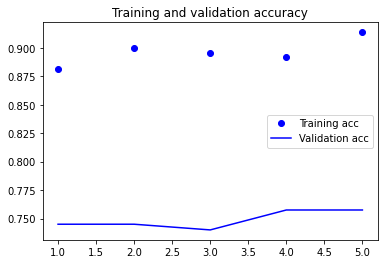

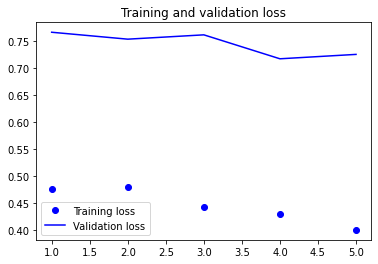

In [14]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

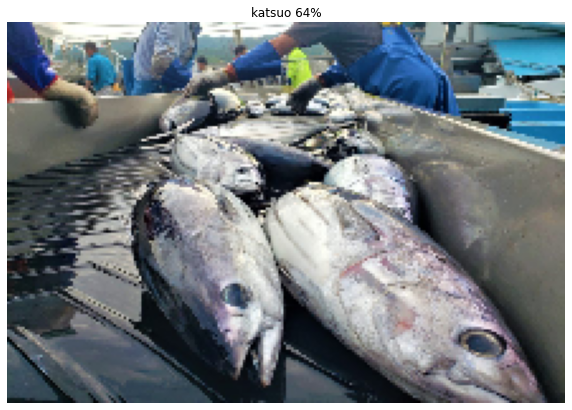

In [39]:
#画像多数の予測
%matplotlib inline
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
img1 = image.load_img('005.jpg', target_size=(image_height, image_width))
img = image.img_to_array(img1)
img = img/255.0
img = np.expand_dims(img, axis=0)
result = model.predict(img)
predicted = result.argmax(axis=1)
plt.figure(figsize=(10,10))
plt.axis("off")
percentage = int(result[0][predicted[0]] * 100)
plt.title(classes[predicted[0]] + " " + str(percentage) + "%")
plt.imshow(img1, cmap=plt.cm.binary)
plt.show()

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


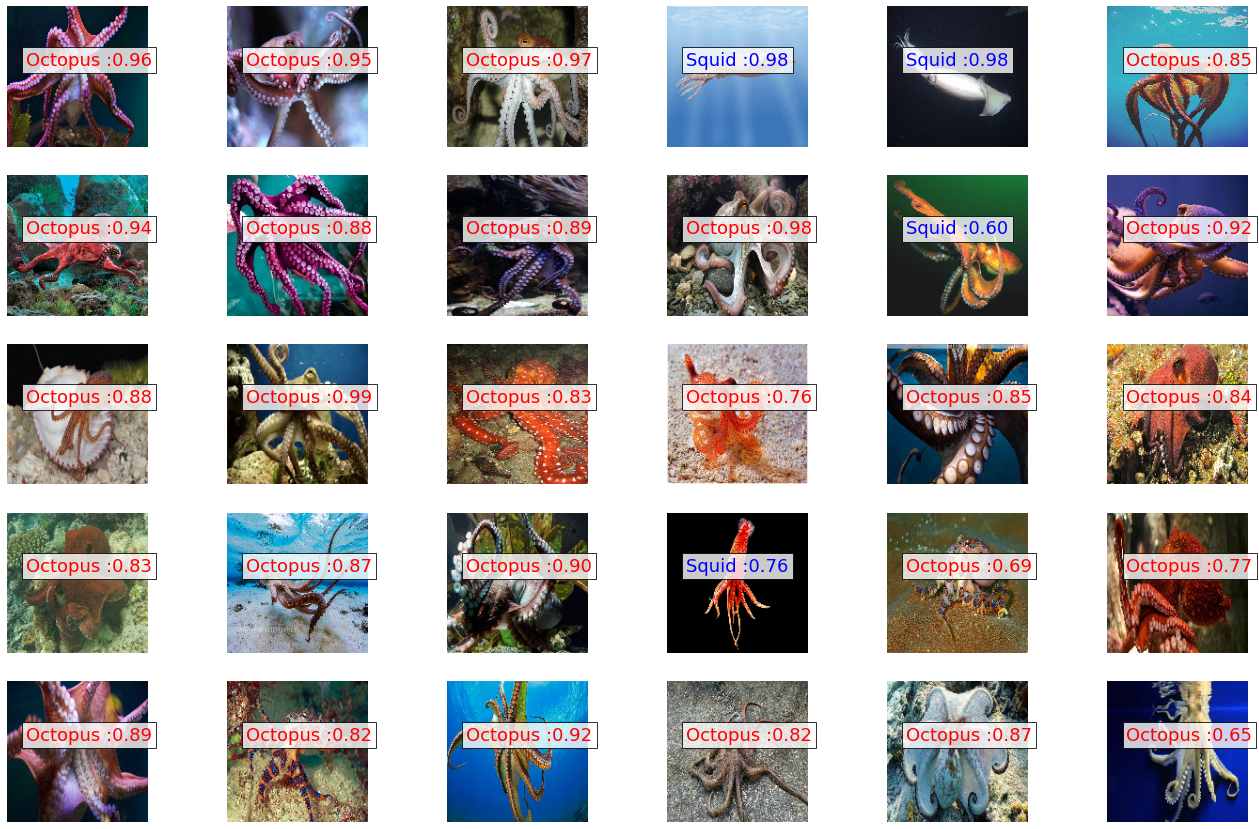

In [ ]:
#画像多数の予測
fig=plt.figure(figsize=(23, 15))
columns = 6
rows = 5
for i in range(columns*rows):
    fig.add_subplot(rows, columns, i+1)
    img1 = image.load_img(str(i) + ".jpg", target_size=(image_size, image_size))
    img = image.img_to_array(img1)
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.
    if(prediction[:,:]>0.5):
      value ='Squid :%1.2f'%(prediction[0,0])
      plt.text(20, 62,value,color='blue',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
      plt.axis("off")
    else:
      value ='Octopus :%1.2f'%(1.0-prediction[0,0])
      plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='white',alpha=0.8))
      plt.axis("off")
    plt.imshow(img1)